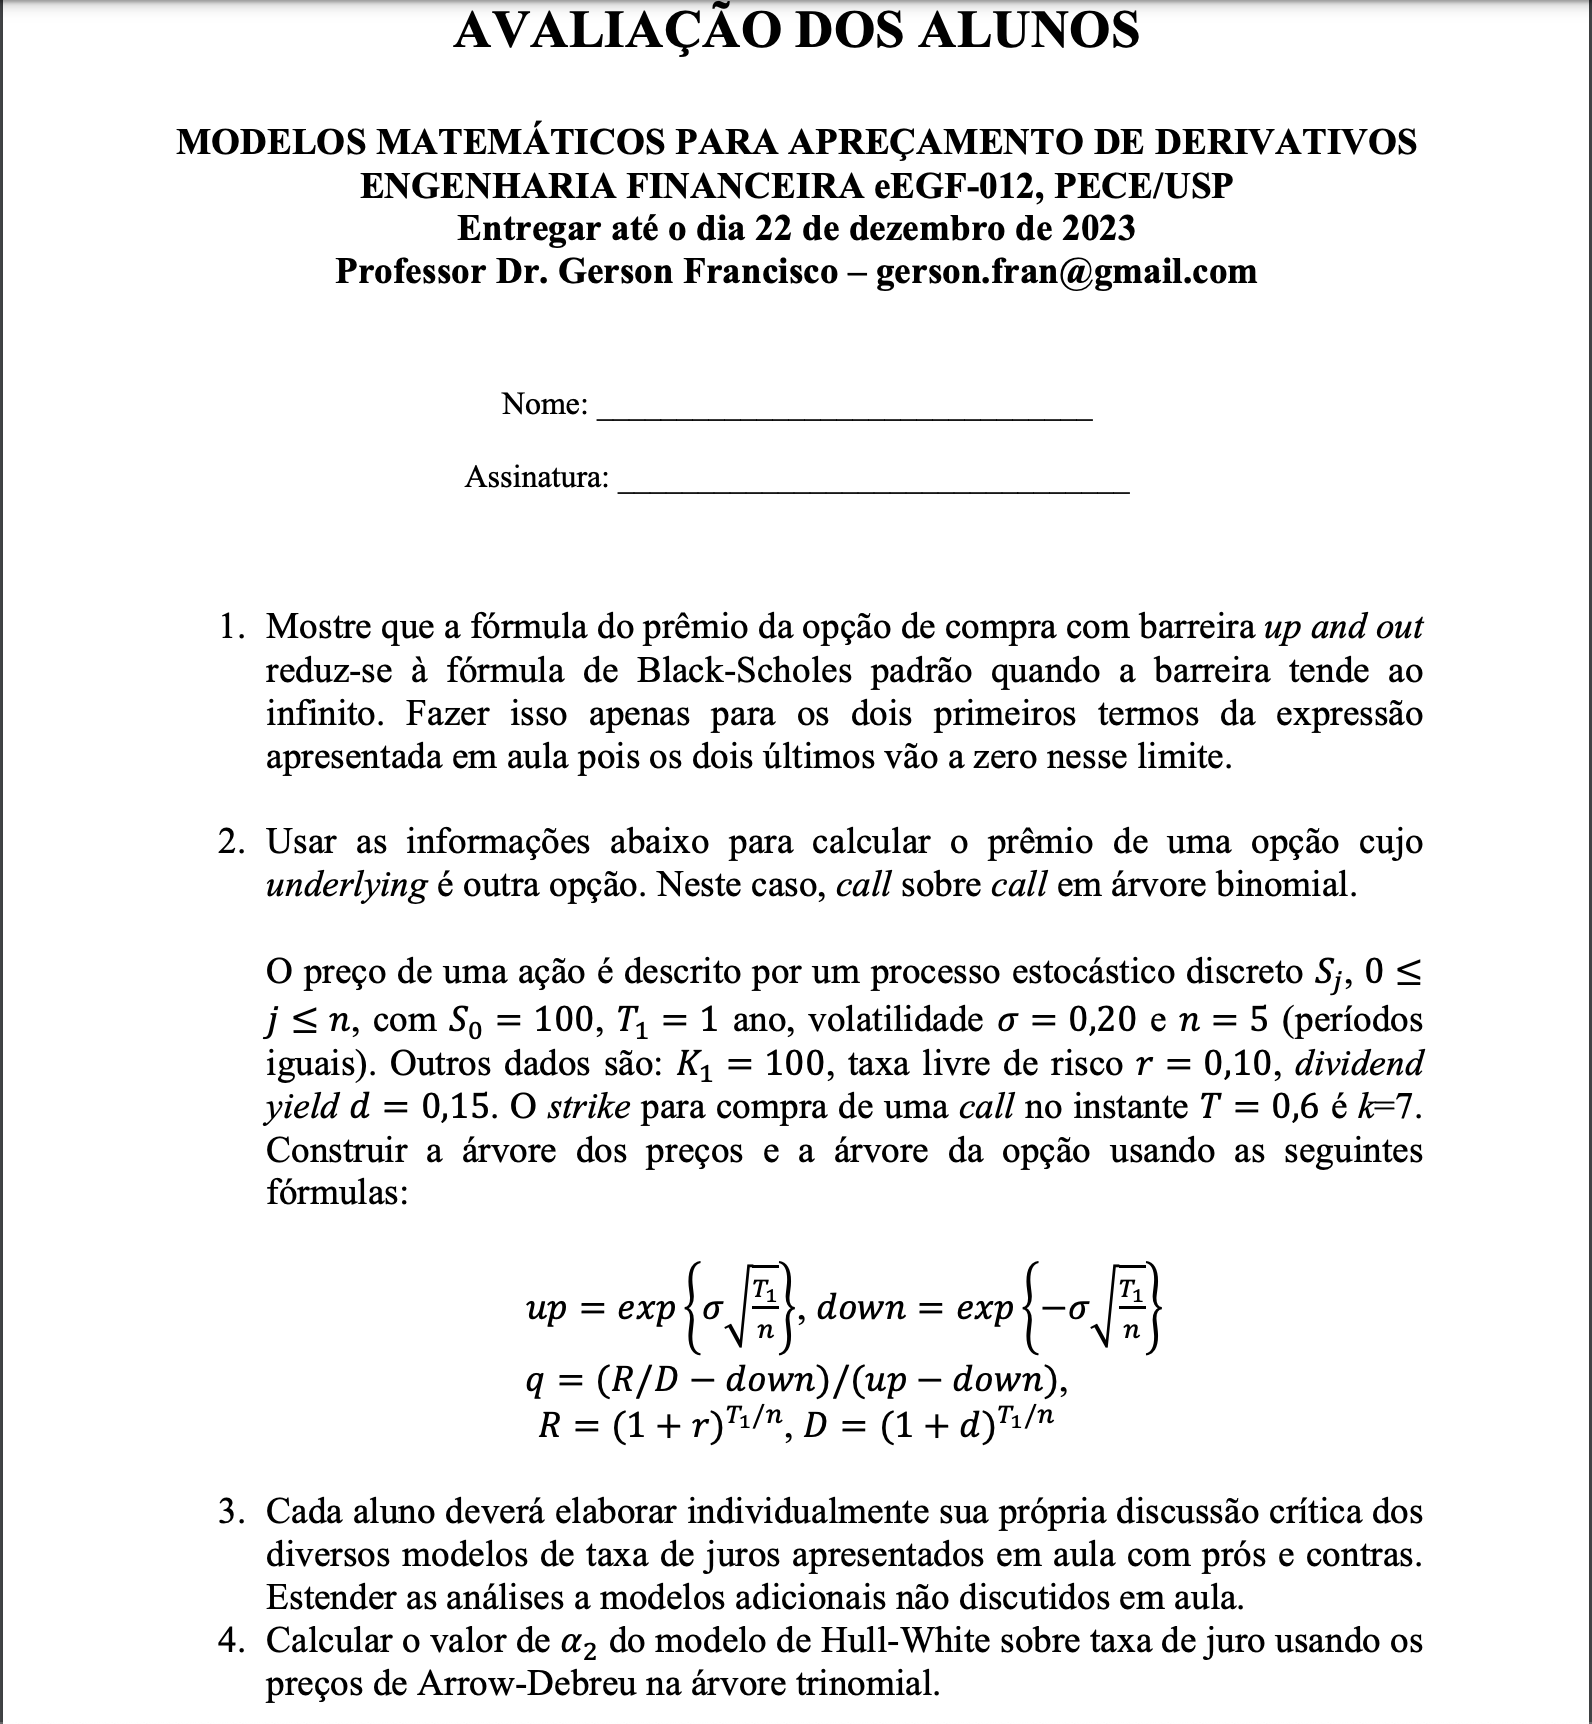

## Aluno: Fernando Gomes Papi

Onde possível, os cálculos foram realizados em Python, com algoritmos desenvolvidos por mim mesmo.

In [38]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import finoptions as fo
import warnings
warnings.filterwarnings('ignore')
import itertools
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
from bin_tree_plotter import BiTreePlotter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1) Up and out com barreira

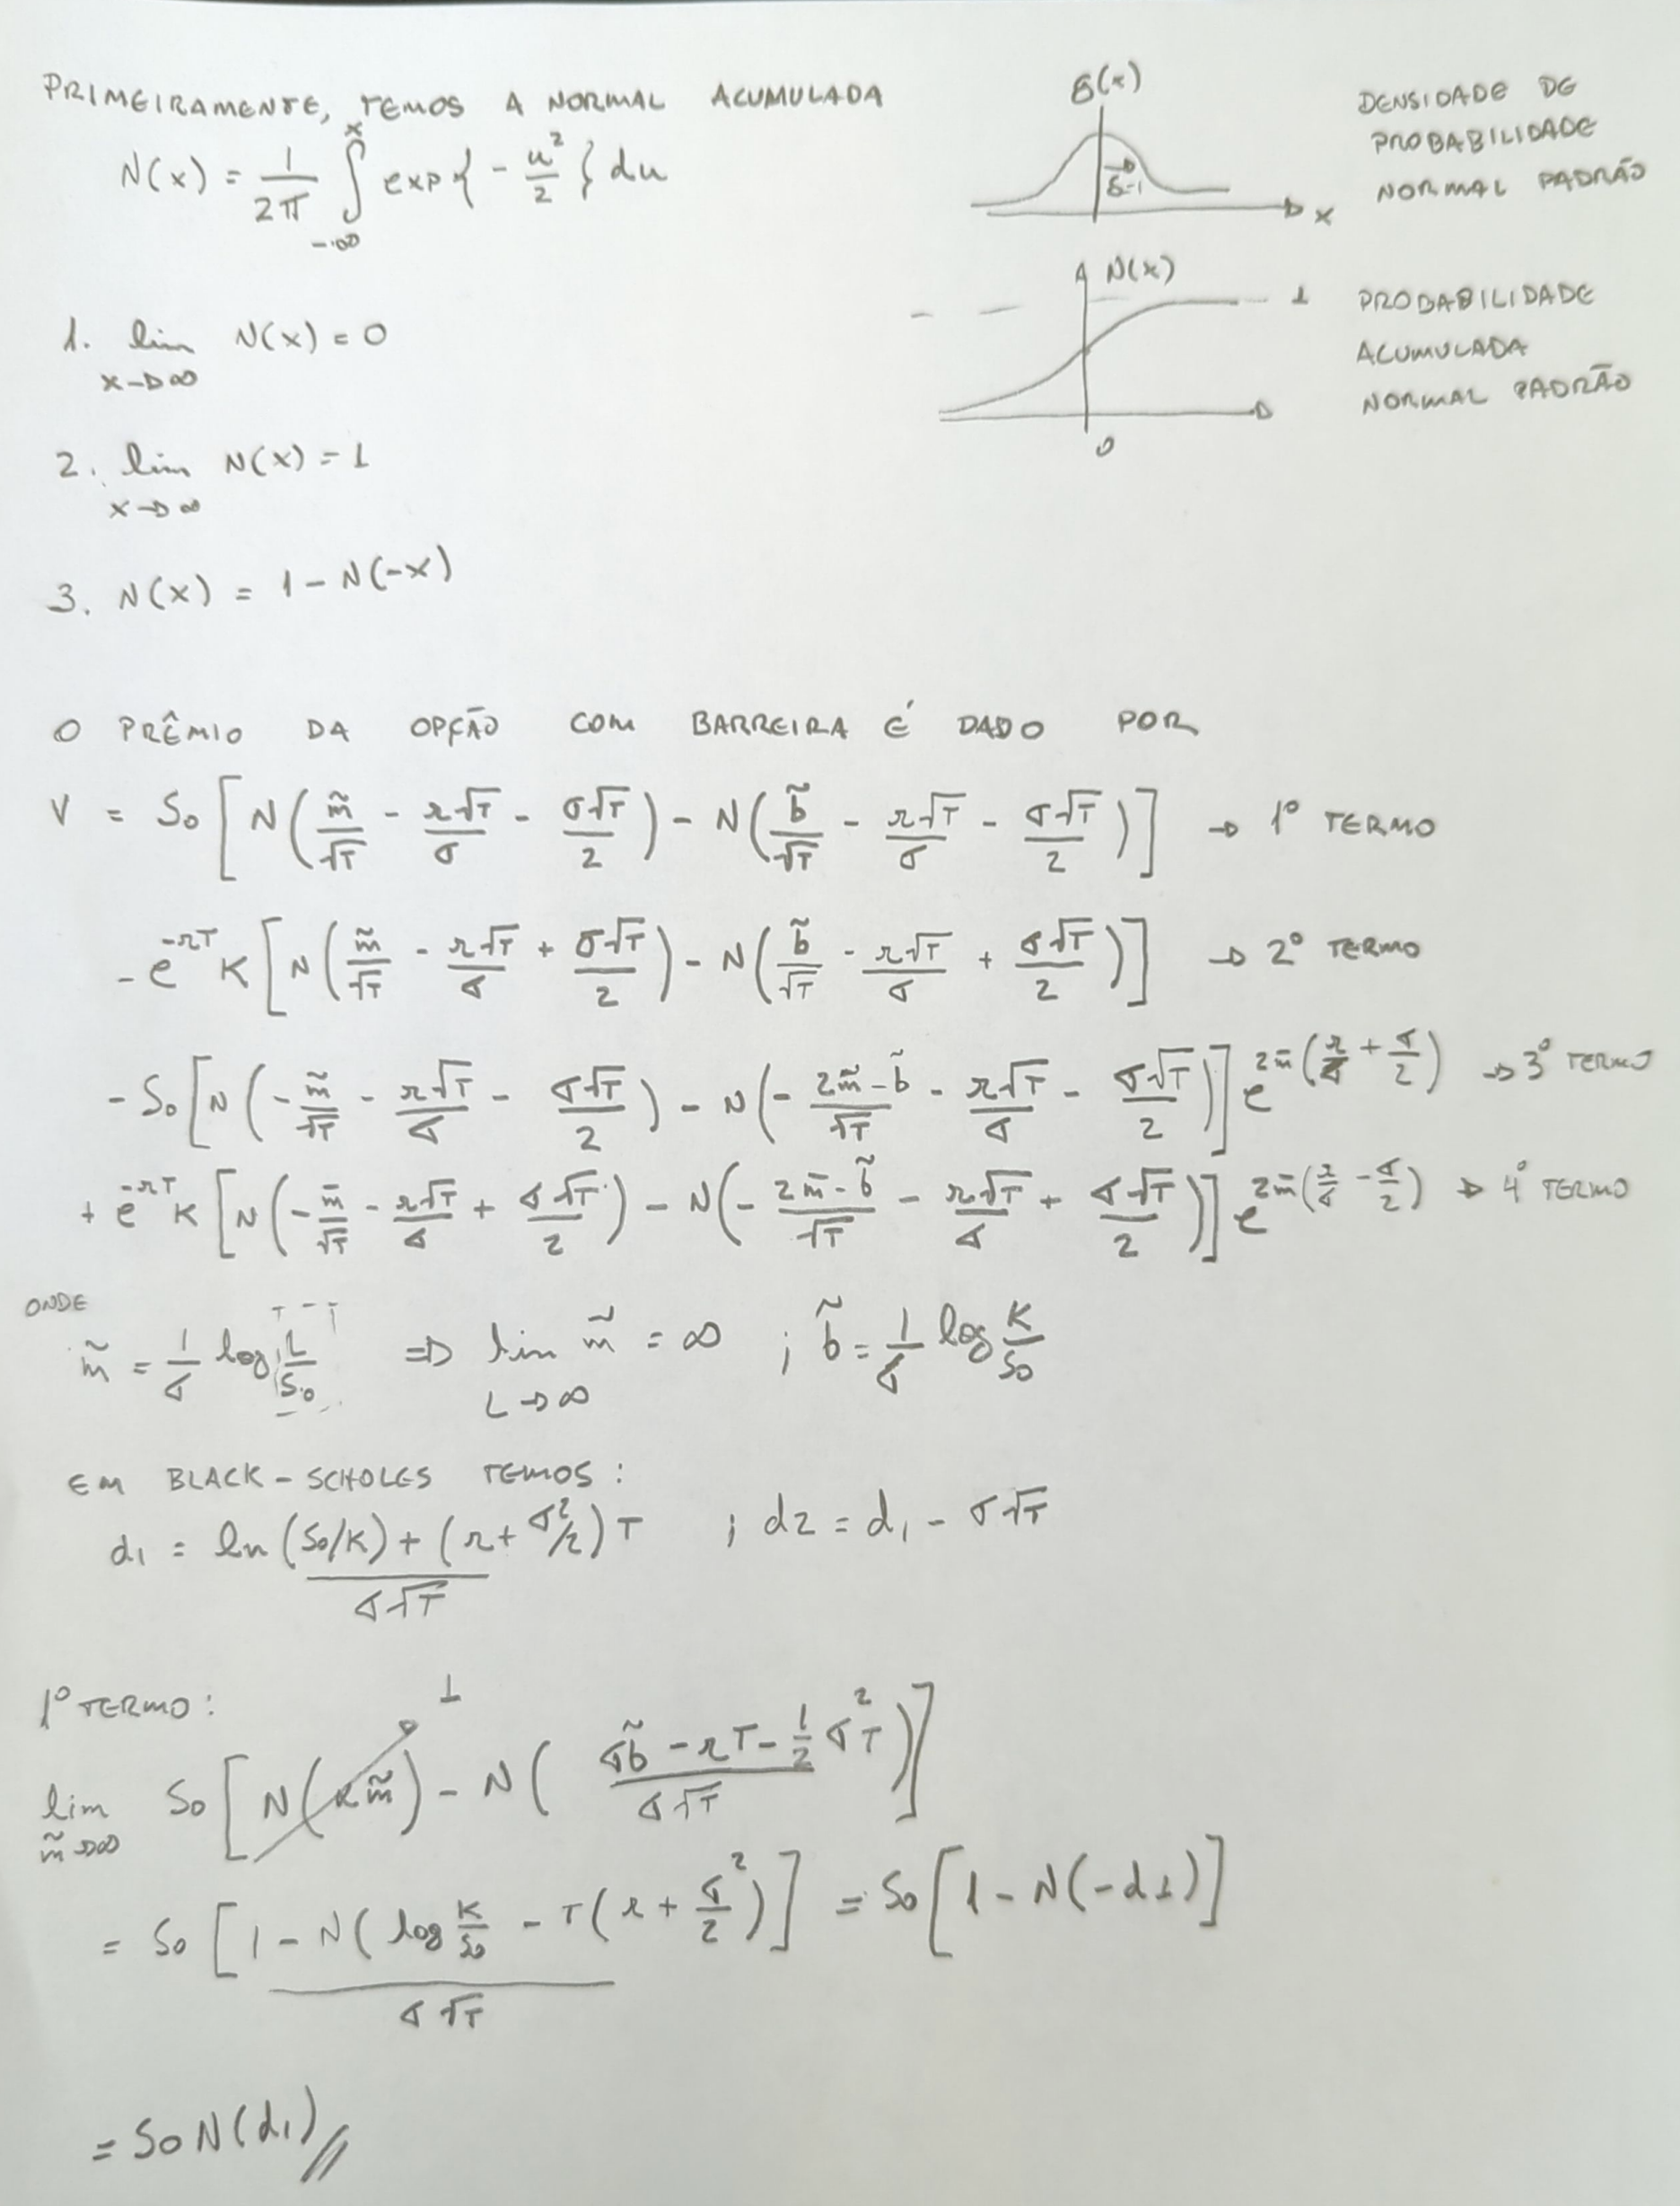

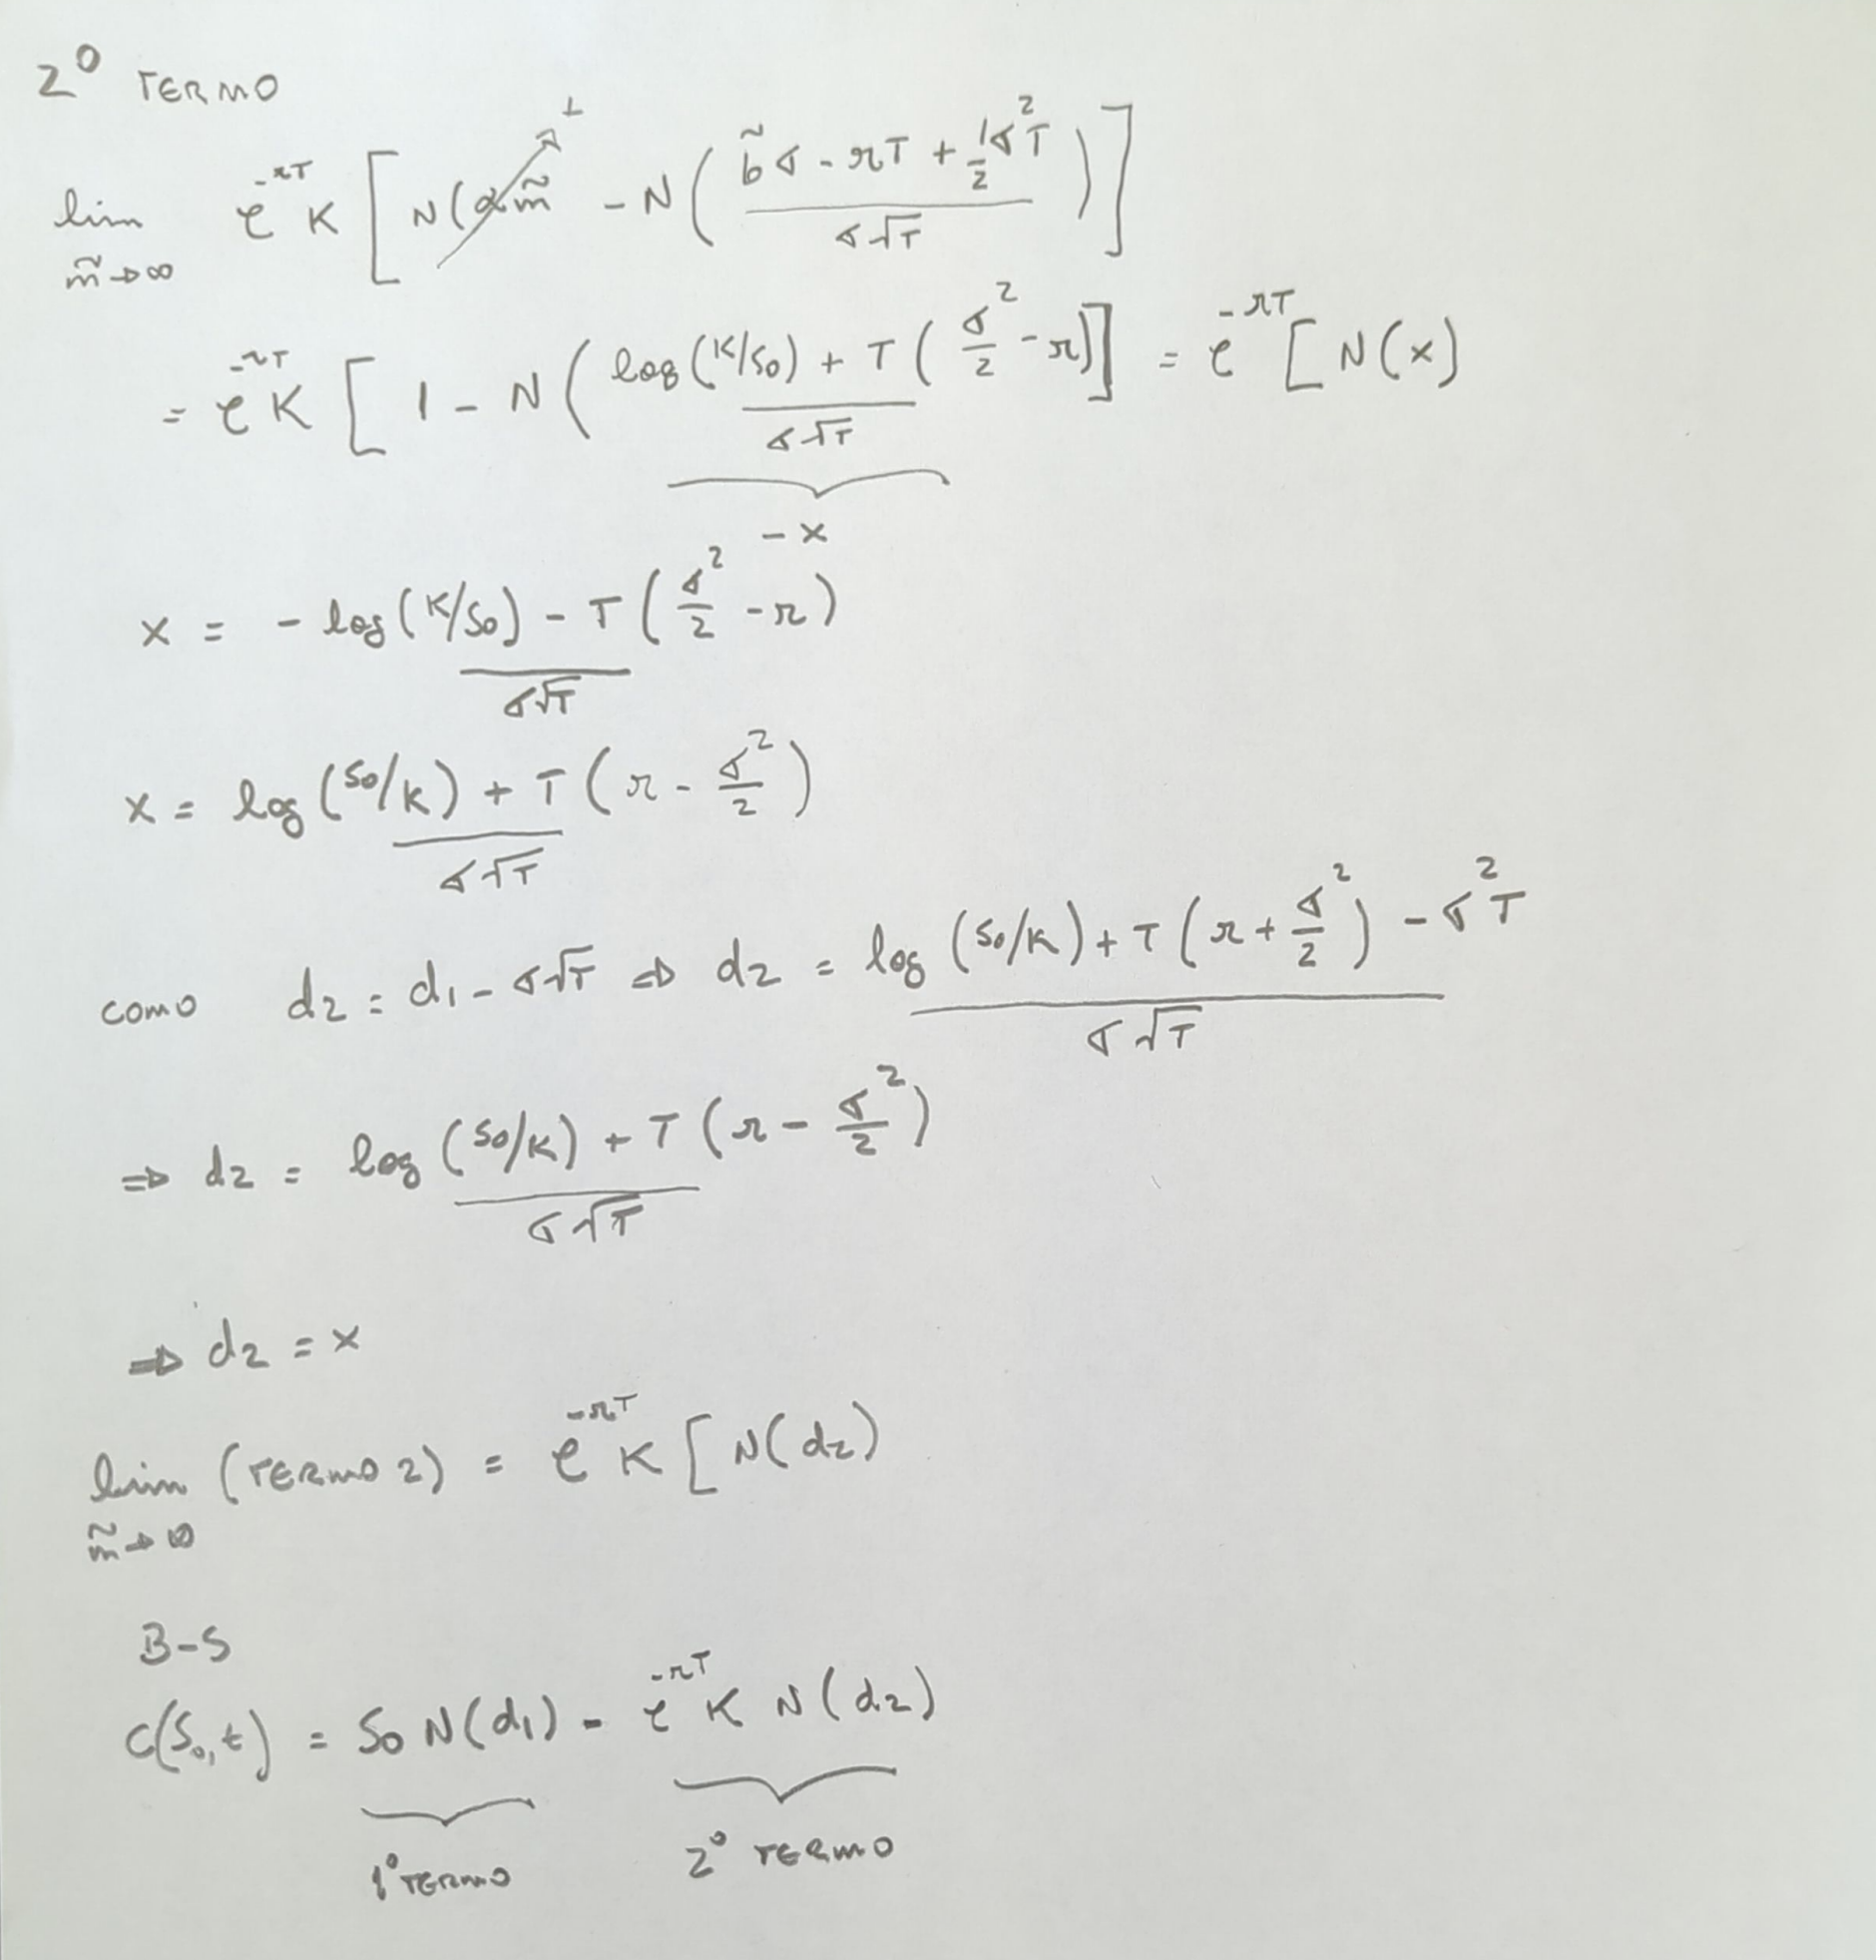

### 2) Opções sobre opções

Função para calcular preços por uma árvore binomial

In [39]:
def binomial_tree_asset_prices(S, T, r, sigma, n):
    # Calcula os fatores de alta (up) e baixa (down) para a árvore binomial
    up = np.exp(sigma * np.sqrt(T / n))
    down = np.exp(-sigma * np.sqrt(T / n))

    # Inicializa a matriz de preços dos ativos em cada nó
    asset_prices = np.zeros((n + 1, n + 1))

    # Preenche a matriz com os preços dos ativos em cada nó
    for i in range(n + 1):
        for j in range(i + 1):
            asset_prices[j, i] = S * (up ** (i - j)) * (down ** j)

    # Retorna a matriz de preços dos ativos em cada nó
    return asset_prices

Primeiramente, com os dados do problema, calculamos o movimento de preço do ativo

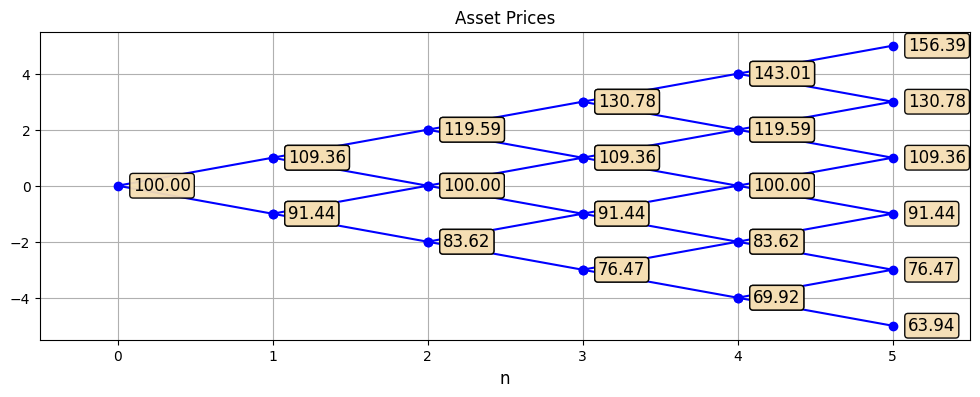

In [40]:
S = 100
K = 100
T = 12/12
r = 0.1
d = 0.15
sigma = 0.2
n = 5
type='european'

R = (1+r)**(T/n)
D = (1+d)**(T/n)

up = np.exp(sigma*np.sqrt(T/n))
down = np.exp(-sigma*np.sqrt(T/n))

q = (R/D-down)/(up-down)

asset_prices = binomial_tree_asset_prices(S, T, r, sigma, n)

# PLota o gráfico
_ = BiTreePlotter(asset_prices).plot(title='Asset Prices')

Depois, fazemos o cálculo do preço das opções a partir dos payoffs descontados pela probabilidade livre de risco

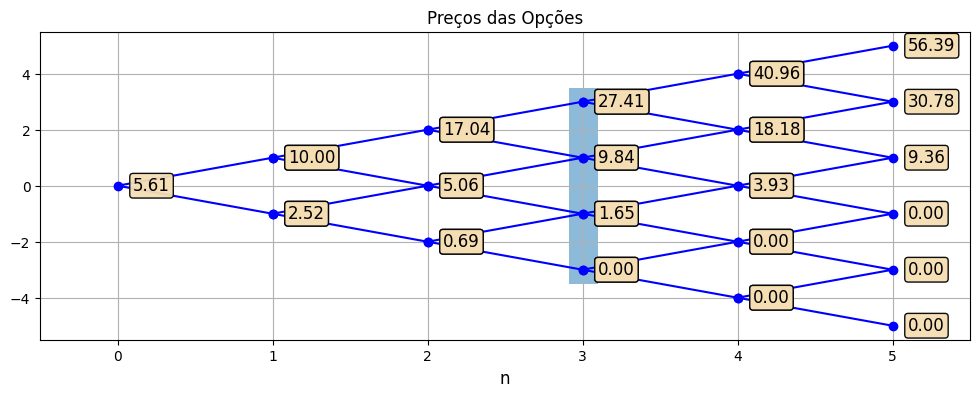

In [41]:
# Calcula os valores das opções utilizando o método de precificação de árvore binomial
# calcula payoffs
options = np.clip(asset_prices - K, 0, np.inf)

# Itera reversamente sobre as colunas da matriz de opções
for i in np.arange(len(options) - 2, -1, -1):
    # Obtém os preços dos ativos no nó superior para a coluna atual
    prices_node = options[:, i + 1]
    # Obtém os preços das opções para a coluna atual
    option_prices = options[:, i][: i + 1]

    # Itera sobre as opções no nó atual
    for idx, node_opt in enumerate(option_prices):
        # Obtém os valores dos nós superior (vup) e inferior (vdown) no nó atual
        vup, vdown = prices_node[idx : idx + 2]
        # Calcula o valor presente do payoff da opção descontada
        v = (1 / R) * (q * vup + (1 - q) * vdown)
        # Atualiza a matriz de opções com o valor presente da opção
        options[idx, i] = v

# Plota a árvore binomial de preços das opções
_ = BiTreePlotter(options).plot(title='Preços das Opções', shade_step=3)

Por fim, olhamos para a árvore do preço das opções em T=3 e, com um strike de 7, calculamos o payoff destas opções nos nós em T=3, e descontamos da mesma maneira até t=0

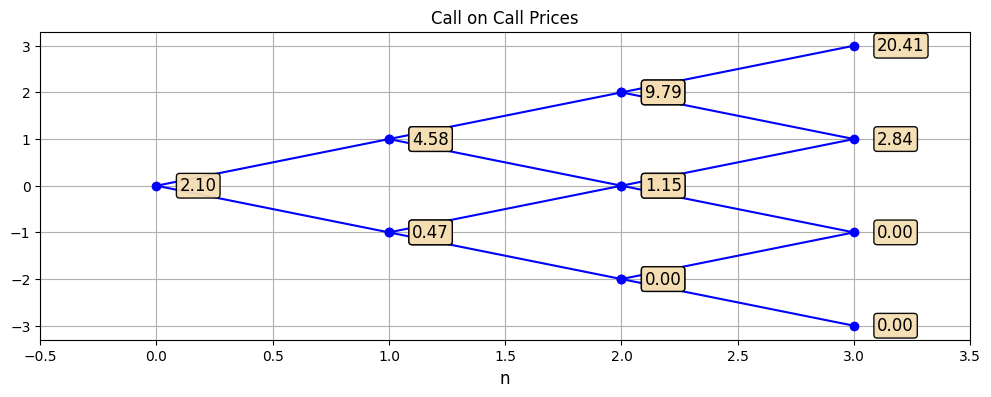

In [42]:
T = 3
strike = 7
R = (1+r)**(T/n)
D = (1+d)**(T/n)

call_on_call = np.clip(options-strike, 0, np.inf)[:,:T+1][:T+1]

for i in np.arange(len(call_on_call)-2, -1, -1):
    prices_node = call_on_call[::,i+1]
    option_prices = call_on_call[::,i][:i+1]
    for idx, node_opt in enumerate(option_prices):
        vup, vdown =  prices_node[idx:idx+2]
        v = (1/R)*(q*vup+(1-q)*vdown)
        call_on_call[idx, i] = v

_ = BiTreePlotter(call_on_call).plot(title='Call on Call Prices')

### 3) Modelos de taxas de juros

De maneira resumida, foram apresentados os modelos de Vasicek, CIR (Cox, Ingersoll and Ross), Ho-Lee, Hull White, além da árvore de taxas de juro.

#### Vasicek

O modelo de Vasicek tem a forma $dr = (\eta - \gamma r)dt + \beta^{1/2}dX$. O modelo é facilmente tratável analiticamente. Apresenta reversão a média, o que é desejável, mas as taxas de juros podem ficar negativas, o que é indesejável

#### CIR

O modelo CIR tem a forma $dr = (\eta - \gamma r)dt + \sqrt{\alpha r} dX$. A taxa apresenta reversão à média e se $\eta > \alpha/2$, as taxas permanecem positivas, o que é desejável. Há algumas tratativas analíticas do modelo, apesar de envolver integrais da distribuição não central de chi-quadrado.

#### Ho-Lee
É o primeiro a introduzir o conceito de não arbitragem. É dado pela forma $dr =  \eta(t) dt + \beta^{1/2} dX$

Se 

$$
\eta(t) = \frac{\partial^2}{\partial t^2} log Z_M(t^*; t) + \beta(t-t*)
$$

então o modelo resultará em preços teóricos de títulos zero cupom, que são iguais aos preços de mercado. Essa técnica também é chamada de ajuste de curva de rendimento (yield curve fitting), onde o dia de hoje é $t^*$. 

O modelo permie taxas negativas e é o de mais fácil calibragem.

#### Hull and White

O modelo de Hull and White extende ambos o modelo de Vasice e CIR para incorporar parâmetros dependentes do tempo. Isso permite o fit da curva de juros como no modelo de Ho-Lee.

O modelo permie taxas negativas e é tratável analiticamente.

### Outros modelos:

#### Heath - Jarrow - Morton

O modelo HJM foi um grande avanço na precificação de produtos de renda fixa. Foi construído um framework que incorpora todos os modelos acima. Mas ao invés de modelar uma taxa curta e derivar a taxa a termo, ele começam com um modelo para toda a curva de juros a termo. Como as taxas a termo são conhecidas hoje, o modelo é feito especialmente para a calibragem (fitting) da curva de juros. Além disso, é possível pegar dados reais de movimentos aleatórios das taxas a termo e incorporá-las na metodologia de apreçamento de derivativos.

O modelo para a assumir que as taxas de juro são processos não-markovianos, isto é, possuem memória. O modelo HJM impede que haja uma PDE definida para o processo, pois um número infinito de termos seria necessário.

#### Brace - Gatarek - Musiela

O modelo BGM modela valores que foram realmente negociados e são observados no mercado de renda fixa. É uma versão discreta do modelo HJM. O modelo é popular entre agentes do mercado de renda fixa pois permite precificar qualquer contrato em que os fluxos de caixa possam ser decompostos em funções da taxa a termo observada.

Ambos HJM e BGM podem ser calibrados por simulações de Monte Carlo.


#### 4) $\alpha_2$ do modelo de Hull-White

Para o exercício estudado, queremos calcular $\alpha_2$, um componente do cálculo dos preços de Arrow-Debreu.

Temos que
$$
P_3 = Q_{22}e^{-r_{2,2}\Delta{t}} + Q_{2,1}e^{-r_{2,1}\Delta{t}} + Q_{2,0}e^{-r_{2,0}\Delta{t}} + Q_{2,-2}e^{-r_{2,-2}\Delta{t}} + Q_{2,-1}e^{-r_{2,-1}\Delta{t}} = e^{-3*0.05086}
$$

onde

$$
r_{2,j} = j\sigma\sqrt{3\Delta t} + \alpha_2; -2 \leq j \leq 2
$$

$\alpha_1$ foi calculado previamente, e temos que $\alpha_1 = 0.05205$.

Da equação de $P_3$, temos:

$$
\alpha_2 = log(\sum{Q_{2,j}e^{R_{2,j}}})
$$

onde $R_{2,j} = j\sigma\sqrt{3\Delta t}$

Os valores $Q_{i,j}$ são o valor de $1 trazido a valor presente no nó e 0 nos demais. As variáveis usadas no código abaixo mapeiam esta árvore:

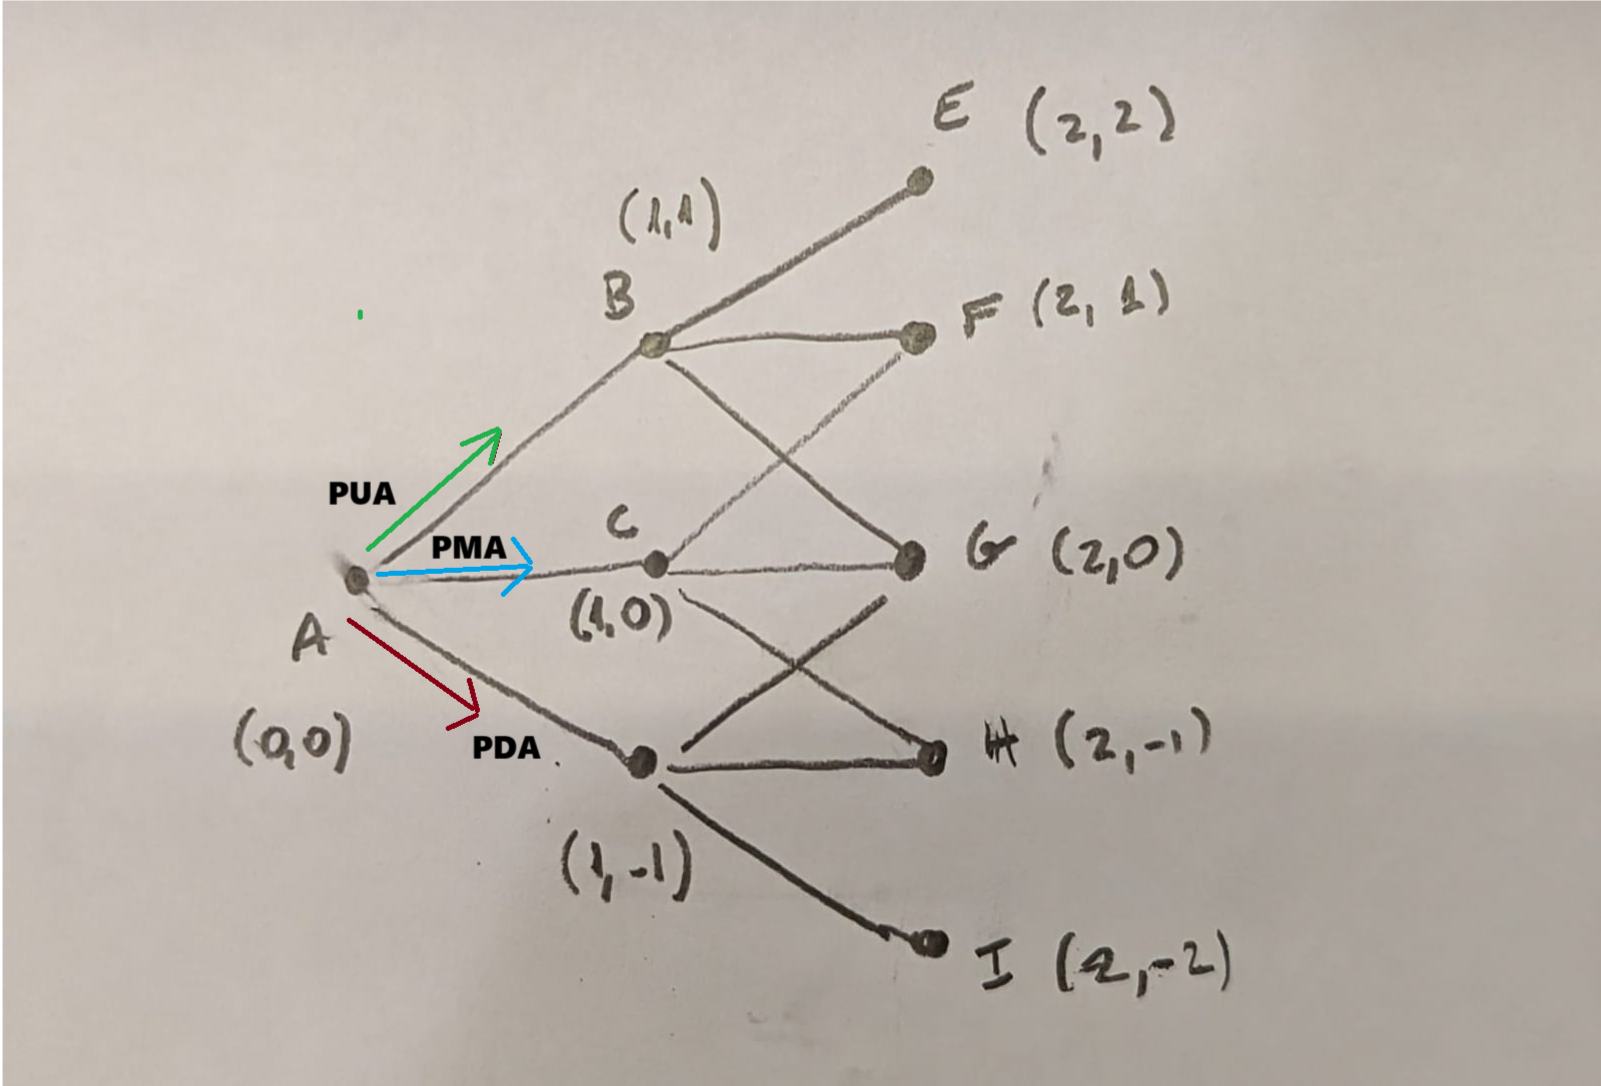

Os valores de $Q{1,j}$ também foram calculados previamente e são: $\{0.1604, 0.6417, 0.1604\}$

A partir destes valores, podemos calcular $Q_{2,j}$ a partir dos nós que são alcançáveis de acordo com a árvore acima.

Por exemplo, o nó $F(Q_{2,1}) = B*pmb*e^{-r_b} + C*puc*e^{-r_c}$ 

Nota: $x$ refere-se a um índice -1 e $z$ refere-se a um índice -2

In [43]:
dt = 1
sigma = 0.01
dR = sigma*np.sqrt(3*dt)
alpha1 = 0.05205

pua, pub, puc, pud, pue, puf, pug, puh, pui = 0.1667, 0.1217, 0.1667, 0.2217, 0.8867, 0.1217, 0.1667, 0.2217, 0.0867
pma, pmb, pmc, pmd, pme, pmf, pmg, pmh, pmi = 0.6666, 0.6566, 0.6666, 0.6566, 0.0266, 0.6566, 0.6666, 0.6566, 0.0266
pda, pdb, pdc, pdd, pde, pdf, pdg, pdh, pdi = 0.1667, 0.2217, 0.1667, 0.1217, 0.0867, 0.2217, 0.1667, 0.1217, 0.8867


RA = 0
RB, RC, RD = 1*dR , 0*dR , -1*dR
RE, RF, RG, RH, RI = 2*dR , 1*dR , 0*dR , -1*dR , -2*dR

r11 = RB + alpha1
r10 = RC + alpha1
r1x = RD + alpha1

Q11 = 0.1604
Q10 = 0.6417
Q1x = 0.1604

Q22 = Q11 * pub * np.exp(-r11*dt)
Q21 = Q11 * pmb * np.exp(-r11*dt) + Q10 * puc * np.exp(-r10*dt)
Q20 = Q11 * pdb * np.exp(-r11*dt) + Q10 * pmc * np.exp(-r10*dt) +  Q1x * pud * np.exp(-r1x*dt)
Q2x = Q10 * pdc * np.exp(-r10*dt) + Q1x * pmd * np.exp(-r1x*dt)
Q2z = Q1x * pdd * np.exp(-r1x*dt)

P3 = np.exp(-3*0.05086)
alpha2 = np.log((Q22 * np.exp(-RE) + Q21 * np.exp(-RF) + Q20 * np.exp(-RG) + Q2x * np.exp(-RH) + Q2z * np.exp(-RI))/P3)
print(f"{alpha2 = }")

alpha2 = 0.06253927842517272
